#Casting defect detection using CNN

## Project Detail  
> In the manufacturing industry, reducing processing errors in the manufacturing process is important for maximizing profits. In order to reduce processing errors, it is necessary to secure a budget for quality assurance, implement manual inspection work, and review the manufacturing process. Particularly, the inspection process is carried out by many companies, but there are problems such as uneven accuracy denpending on inspection workers and increased labor costs.  
> In this analysis, we will verify whether the bottleneck of "manual inspection" can be cleared by automating the inspection process by machine learning in the manufacturing process of [casting products](https://en.wikipedia.org/wiki/Casting_%28metalworking%29). [Casting](https://en.wikipedia.org/wiki/Casting) is a technique in which molten metal is poured into a mold and processed into a desired shape.  
> According to [this article](https://en.wikipedia.org/wiki/Casting_defect), the following are some of the defects in the casting process.
> * blow holes
> * pinholes
> * burr
> * shrinkage defects
> * mould material defects
> * pouring metal defects
> * metallurgical defects

## About Dataset
> This dataset provides image data of impellers for submersible pumps.<br/><br/>




# 2. Import libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline
import cv2
import warnings
warnings.filterwarnings('ignore')
import json

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend
from sklearn.metrics import confusion_matrix, classification_report

# 3. Load the dataset

In [ ]:
!unzip '/content/casting_data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: casting_data/train/def_front/cast_def_0_526.jpeg  
  inflating: casting_data/train/def_front/cast_def_0_5260.jpeg  
  inflating: casting_data/train/def_front/cast_def_0_5262.jpeg  
  inflating: casting_data/train/def_front/cast_def_0_5265.jpeg  
  inflating: casting_data/train/def_front/cast_def_0_527.jpeg  
  inflating: casting_data/train/def_front/cast_def_0_5270.jpeg  
  inflating: casting_data/train/def_front/cast_def_0_5272.jpeg  
  inflating: casting_data/train/def_front/cast_def_0_5274.jpeg  
  inflating: casting_data/train/def_front/cast_def_0_528.jpeg  
  inflating: casting_data/train/def_front/cast_def_0_5282.jpeg  
  inflating: casting_data/train/def_front/cast_def_0_5283.jpeg  
  inflating: casting_data/train/def_front/cast_def_0_5284.jpeg  
  inflating: casting_data/train/def_front/cast_def_0_5285.jpeg  
  inflating: casting_data/train/def_front/cast_def_0_5286.jpeg  
  inflating: casting_data/train/def_front/

In [ ]:
my_data_dir = '/content/casting_data'
train_path = '/content/casting_data/train/'
test_path = '/content/casting_data/test/'

#EDA(Exploratory data analysis)

In [ ]:
train_defective= '/content/casting_data/train/def_front'
train_ok = '/content/casting_data/train/ok_front'
test_defective = '/content/casting_data/test/def_front'
test_ok = '/content/casting_data/test/ok_front'

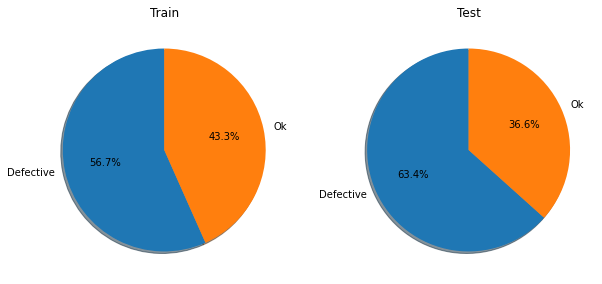

 Defective Training Images 	: 3758
 Ok Training Images 		: 2875

 Defective Testing Images 	: 453
 Ok Testing Images 		: 262


In [ ]:
x_train = np.array([len(os.listdir(train_defective)),len(os.listdir(train_ok))])
x_test = np.array([len(os.listdir(test_defective)),len(os.listdir(test_ok))])
label = ['Defective','Ok']
  
fig, axes = plt.subplots(1, 2, figsize=(10,6))
axes[0].pie(x_train, labels=label, shadow=True,autopct='%1.1f%%', startangle=90)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Train')
axes[1].set_title('Test')
plt.show()

print(' Defective Training Images \t: ' + str(len(os.listdir(train_defective))))
print(' Ok Training Images \t\t: ' + str(len(os.listdir(train_ok))))
print()
print(' Defective Testing Images \t: ' + str(len(os.listdir(test_defective))))
print(' Ok Testing Images \t\t: ' + str(len(os.listdir(test_ok))))

#All input image size are 300 x 300

#display ok and defective image

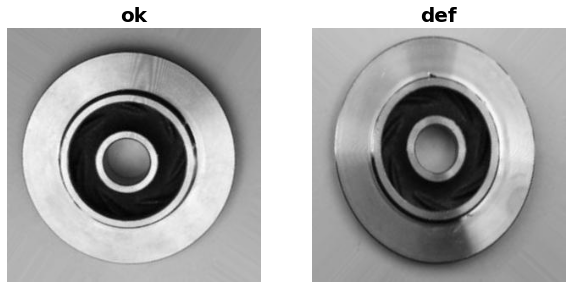

In [ ]:
plt.figure(figsize=(10,8))

ok = plt.imread('/content/casting_data/train/ok_front/cast_ok_0_1.jpeg')

plt.subplot(1, 2, 1)

plt.axis('off')

plt.title("ok", weight='bold', size=20)

plt.imshow(ok,cmap='gray')

ng = plt.imread('/content/casting_data/train/def_front/cast_def_0_1001.jpeg')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("def", weight='bold', size=20)
plt.imshow(ng,cmap='gray')

plt.show()

# 4. Pre-Processing
The first step of preparing the data is to normalize pixel values (originally between 0 and 255) to a range of 0 to 1. This is done by passing the rescale arguments on instances of Keras ImageDataGenerator for train and test sets.

With the train set generator we specify validation_split=0.2 to reserve 20% of data for validation. The function flow_from_directory() is then used on the data generators for each of train/ and test/ directories. Arguments for data generation are also specified:

Target image size is 300×300 pixels

color_mode='grayscale' to convert images as having 1 channel

Define class mapping: 0 for OK, 1 for Defective

class_mode='binary' since there are two classes

Batch size fixed at 32

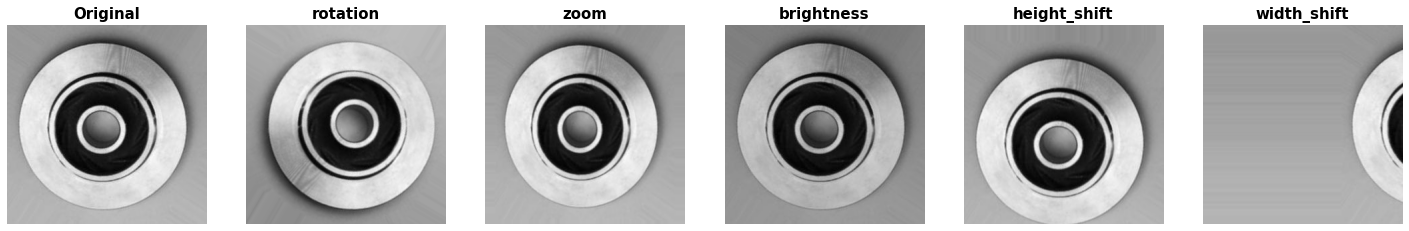

In [ ]:
img = cv2.imread('/content/casting_data/train/ok_front/cast_ok_0_1.jpeg')

img_4d = img[np.newaxis]

plt.figure(figsize=(25,10))
generators = {"rotation":ImageDataGenerator(rotation_range=180), 
              "zoom":ImageDataGenerator(zoom_range=0.7), 
              "brightness":ImageDataGenerator(brightness_range=[0.2,1.0]), 
              "height_shift":ImageDataGenerator(height_shift_range=0.7), 
              "width_shift":ImageDataGenerator(width_shift_range=0.7)}

plt.subplot(1, 6, 1)
plt.title("Original", weight='bold', size=15)
plt.imshow(img)
plt.axis('off')

cnt = 2
for param, generator in generators.items():
    image_gen = generator
    gen = image_gen.flow(img_4d, batch_size=1)
    batches = next(gen)
    g_img = batches[0].astype(np.uint8)
    plt.subplot(1, 6, cnt)
    plt.title(param, weight='bold', size=15)
    plt.imshow(g_img)
    plt.axis('off')
    cnt += 1
plt.show()

## Execute Data Augmentation


In [ ]:
image_gen = ImageDataGenerator(rescale=1/255, 
                               zoom_range=0.1, 
                               brightness_range=[0.9,1.0])

In [ ]:
image_shape = (300,300,1) # 300 × 300、graysclaed (full-color : 3)
batch_size = 32

train_set = image_gen.flow_from_directory(train_path,
                                            target_size=image_shape[:2],
                                            color_mode="grayscale",
                                            classes={'def_front': 0, 'ok_front': 1},
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            seed=0)

test_set = image_gen.flow_from_directory(test_path,
                                           target_size=image_shape[:2],
                                           color_mode="grayscale",
                                           classes={'def_front': 0, 'ok_front': 1},
                                           batch_size=batch_size,
                                           class_mode='binary',
                                           seed=0)

Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [ ]:
train_set.class_indices

{'def_front': 0, 'ok_front': 1}

# 5. Modeling

In [ ]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(7,7), strides=2, input_shape=image_shape, activation='relu', padding='same'))


model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(units=224, activation='relu'))           

model.add(Dropout(rate=0.2))

model.add(Dense(units=1, activation='sigmoid'))         

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      800       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0

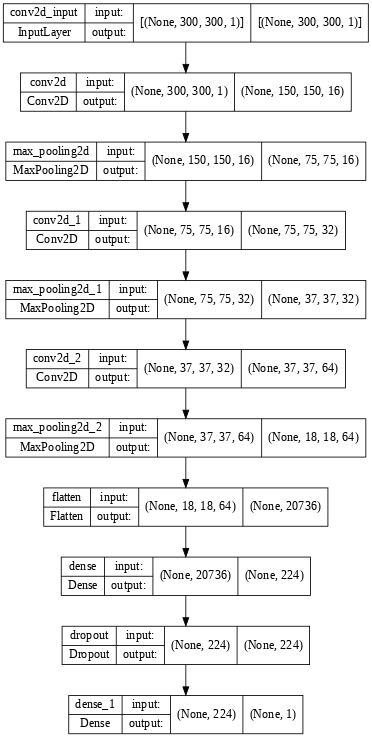

In [ ]:
plot_model(model, show_shapes=True, expand_nested=True, dpi=60)

## Build Model


In [ ]:
model_save_path = 'casting_product_detection.hdf5'
early_stop = EarlyStopping(monitor='val_loss',patience=2)
checkpoint = ModelCheckpoint(filepath=model_save_path, verbose=1, save_best_only=True, monitor='val_loss')

In [ ]:
n_epochs = 20
results = model.fit_generator(train_set, epochs=n_epochs, validation_data=test_set, callbacks=[early_stop,checkpoint])

Epoch 1/20
208/208 [==============================] - ETA: 0s - loss: 0.5732 - accuracy: 0.6940
Epoch 1: val_loss improved from inf to 0.45930, saving model to /content/sample_data/output
INFO:tensorflow:Assets written to: /content/sample_data/output/assets
208/208 [==============================] - 80s 332ms/step - loss: 0.5732 - accuracy: 0.6940 - val_loss: 0.4593 - val_accuracy: 0.7734
Epoch 2/20
208/208 [==============================] - ETA: 0s - loss: 0.3073 - accuracy: 0.8654
Epoch 2: val_loss improved from 0.45930 to 0.23165, saving model to /content/sample_data/output
INFO:tensorflow:Assets written to: /content/sample_data/output/assets
208/208 [==============================] - 70s 336ms/step - loss: 0.3073 - accuracy: 0.8654 - val_loss: 0.2316 - val_accuracy: 0.9175
Epoch 3/20
208/208 [==============================] - ETA: 0s - loss: 0.1929 - accuracy: 0.9246
Epoch 3: val_loss improved from 0.23165 to 0.14405, saving model to /content/sample_data/output
INFO:tensorflow:Asse

In [ ]:
model_history = results.history
json.dump(model_history, open('model_history.json', 'w'))

## Model Performance

In [ ]:
Model_performance = pd.DataFrame(model_history)
losses.index = map(lambda x : x+1, losses.index)
Model_performance.head(10)

,loss,accuracy,val_loss,val_accuracy
1,0.573154,0.693954,0.459303,0.773427
2,0.307309,0.865370,0.231648,0.917482
3,0.192858,0.924619,0.144054,0.949650
4,0.146177,0.945575,0.135477,0.952448
5,0.103135,0.960802,0.067662,0.979021
6,0.084257,0.968943,0.101578,0.955245
7,0.061478,0.980250,0.047447,0.990210
8,0.062923,0.979496,0.046979,0.981818
9,0.034135,0.989447,0.024879,0.993007
10,0.036636,0.987788,0.024963,0.987413


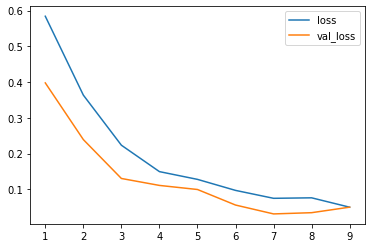

In [ ]:
Model_performance[['loss','val_loss']].plot()

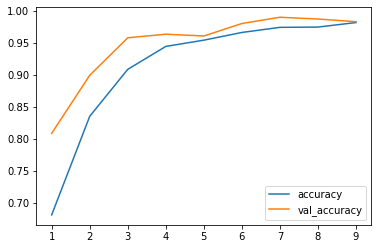

In [ ]:
Model_performance[['accuracy','val_accuracy']].plot()

#confusion matrix

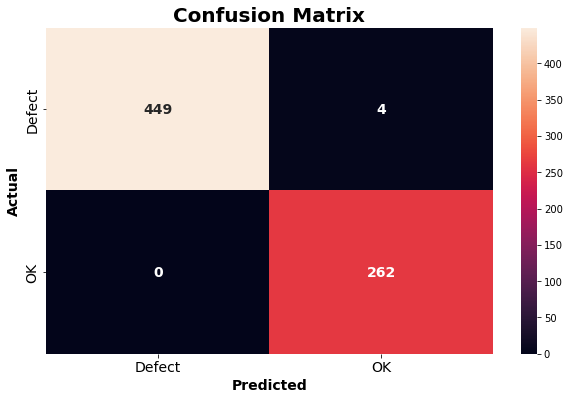

In [ ]:
pred_probability = model.predict_generator(test_set)
predictions = pred_probability > 0.5

plt.figure(figsize=(10,6))
plt.title("Confusion Matrix", size=20, weight='bold')

sns.heatmap(
    confusion_matrix(test_set.classes, predictions),
    annot=True,
    annot_kws={'size':14, 'weight':'bold'},
    fmt='d',
    xticklabels=['Defect', 'OK'],
    yticklabels=['Defect', 'OK'])
plt.tick_params(axis='both', labelsize=14)

plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.show()

In [ ]:
print(classification_report(test_set.classes, predictions, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.991     0.996       453
           1      0.985     1.000     0.992       262

    accuracy                          0.994       715
   macro avg      0.992     0.996     0.994       715
weighted avg      0.994     0.994     0.994       715



## Predict on Some Images


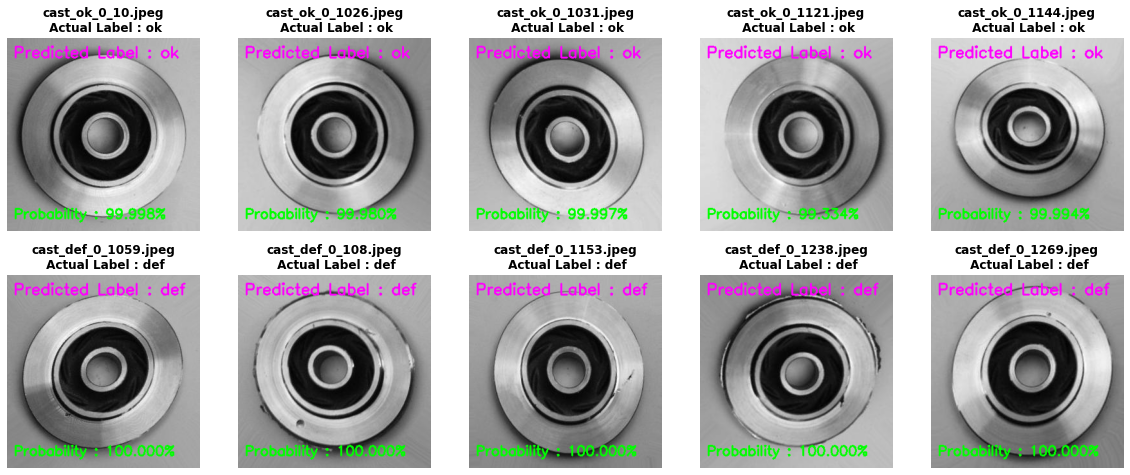

In [ ]:
test_cases = ['ok_front/cast_ok_0_10.jpeg','ok_front/cast_ok_0_1026.jpeg', 'ok_front/cast_ok_0_1031.jpeg', 'ok_front/cast_ok_0_1121.jpeg', \
              'ok_front/cast_ok_0_1144.jpeg','def_front/cast_def_0_1059.jpeg', 'def_front/cast_def_0_108.jpeg', 'def_front/cast_def_0_1153.jpeg',\
              'def_front/cast_def_0_1238.jpeg', 'def_front/cast_def_0_1269.jpeg']

plt.figure(figsize=(20,8))
for i in range(len(test_cases)):
    img_pred = cv2.imread(test_path + test_cases[i], cv2.IMREAD_GRAYSCALE)
    img_pred = img_pred / 255 # rescale
    prediction = model.predict(img_pred.reshape(1, *image_shape))

    img = cv2.imread(test_path + test_cases[i])
    label = test_cases[i].split("_")[0]
    
    plt.subplot(2, 5, i+1)
    plt.title(f"{test_cases[i].split('/')[1]}\n Actual Label : {label}", weight='bold', size=12)
    if (prediction < 0.5):
        predicted_label = "def"
        prob = (1-prediction.sum()) * 100
    else:
        predicted_label = "ok"
        prob = prediction.sum() * 100
        
    cv2.putText(img=img, text=f"Predicted Label : {predicted_label}", org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(255, 0, 255), thickness=2)
    cv2.putText(img=img, text=f"Probability : {'{:.3f}'.format(prob)}%", org=(10, 280), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=(0, 255, 0), thickness=2)
    plt.imshow(img,cmap='gray')
    plt.axis('off')

plt.show()